In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from prediction_pipeline.preprocessing import *
from prediction_pipeline.build_sysmex_features import *
from prediction_pipeline.training import *
from sklearn.manifold import TSNE
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression
from matplotlib.patches import Patch
from tqdm import tqdm

In [2]:
data_dir = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/data_home"
training_data = "%s/training_exports" % data_dir
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"

# interval phenotypes

## Load

In [3]:
meta = pd.read_csv("/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_HAAS/meta_table.tsv", sep="\t")

In [4]:
pheno = pd.read_csv("/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_phenotypes/INTERVALdata_14MAY2020.csv",sep=",", encoding = "ISO-8859-1")

In [29]:
meta.head()

,FileName,SampleNo,Instrument,DateTime,DateTime_rank,SampleType,WithinSampleRank,EpiCovId_bl,EpiCovId_24m,EpiCovId_48m,EpiCovId_p3
0,[XN-10^11041][00-11_8][20130301_090955][ ...,QC-30141103,XN-10^11041,2013-03-01 09:09:55,1.0,QC,1,NaN,NaN,NaN,NaN
1,[XN-10^11041][00-11_8][20130301_101944][ ...,INT_116_6580100,XN-10^11041,2013-03-01 10:19:44,2.0,NHSBT,1,1090916.0,NaN,NaN,NaN
2,[XN-10^11041][00-11_8][20130301_102100][ ...,INT_116_6580000,XN-10^11041,2013-03-01 10:21:00,3.0,NHSBT,1,1111731.0,NaN,NaN,NaN
3,[XN-10^11041][00-11_8][20130301_102216][ ...,INT_116_2129800,XN-10^11041,2013-03-01 10:22:16,4.0,NHSBT,1,1070498.0,NaN,NaN,NaN
4,[XN-10^11041][00-11_8][20130301_102333][ ...,INT_116_4555900,XN-10^11041,2013-03-01 10:23:33,5.0,NHSBT,1,1042358.0,NaN,NaN,NaN


In [30]:
meta["machine"] = meta.FileName.str.contains("XN-10^11041",regex=False)

## Select

In [31]:
meta["valid_id"] = meta["EpiCovId_24m"]
meta.loc[~meta["EpiCovId_bl"].isnull(), "valid_id"] = meta.loc[~meta["EpiCovId_bl"].isnull(),"EpiCovId_bl"]

In [32]:
df = pd.merge(meta, pheno, left_on="valid_id", right_on="identifier")
df["DateTime"] = pd.to_datetime(df["DateTime"], format="%Y-%m-%d %H:%M:%S")
df = df.sort_values("DateTime",ascending=True).drop_duplicates("valid_id",keep="first")
df.rename(columns={'PLT_10_9_L_bl':"PLT",'MPV_fL_bl':"MPV",'PCT_PCT_bl':"PCT",'PDW_fL_bl':"PDW"},inplace=True)

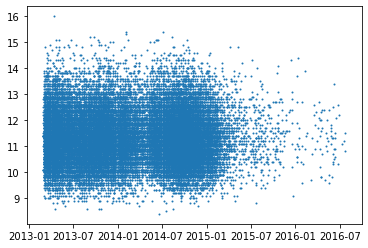

In [33]:
plt.scatter(df["DateTime"], df.MPV,s=1)

In [34]:
df = df.loc[df.PLT > 20]

In [35]:
df["days"] = (df["DateTime"] - df["DateTime"].min()).dt.days
df["months"] = df["days"] // 30

In [36]:
month_number = df.groupby("months")["PLT"].count()

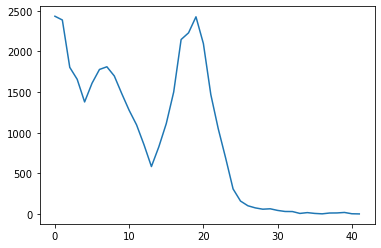

In [37]:
plt.figure()
plt.plot(month_number.index,month_number)

In [38]:
df_full = df.loc[df.months < 25].copy()

In [39]:
df_full.to_hdf("%s/meta_recap.hdf" % export_folder,key="meta")

## Adjust

### Time

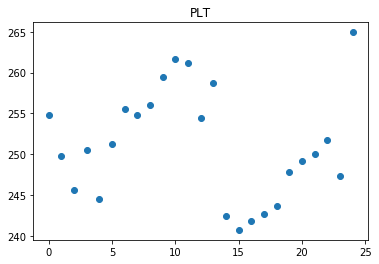

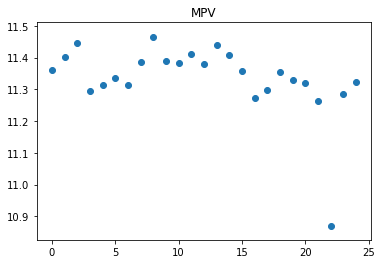

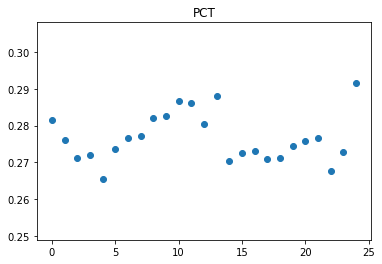

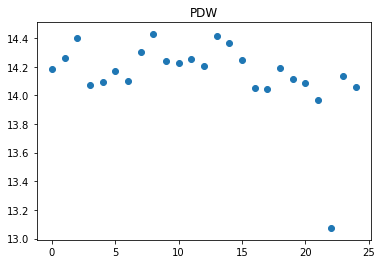

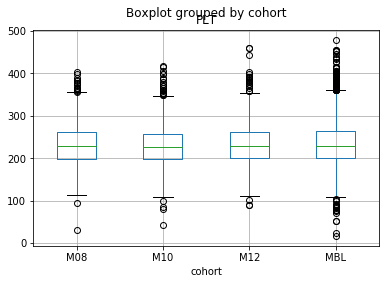

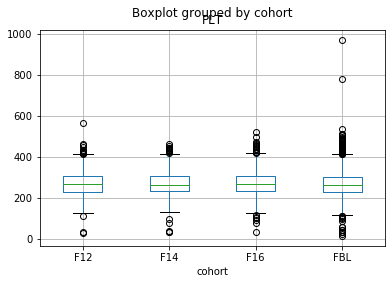

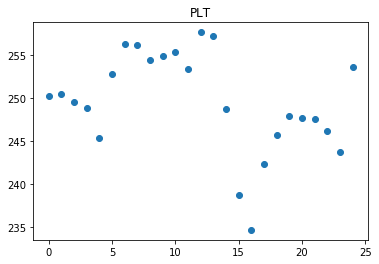

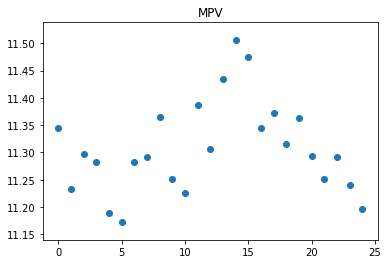

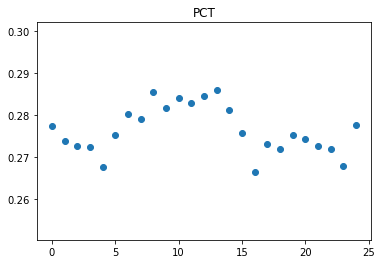

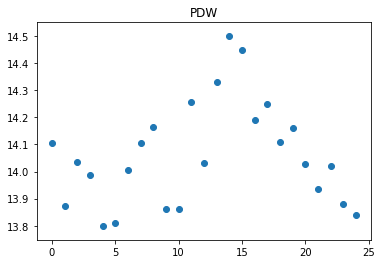

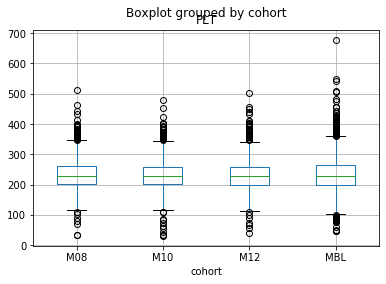

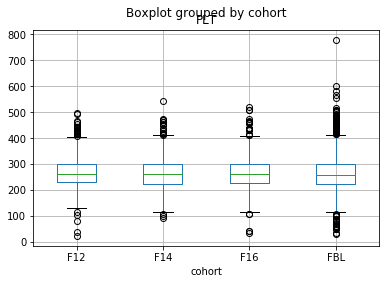

In [16]:
dfs = []
for machine in df_full.machine.unique():
    df = df_full.loc[df_full.machine == machine]
    month_avg = df.groupby("months")[["PLT","MPV","PCT","PDW"]].mean()

    for c in month_avg:
        plt.figure()
        plt.scatter(month_avg.index,month_avg[c],label=c)
        plt.title(c)

    offset = month_avg - df[month_avg.columns].mean()

    df_adj = df[month_avg.columns] - pd.merge(df[["months"]], offset, right_index=True,left_on="months",how="left")[month_avg.columns]
    df[[c+"_RAW" for c in df_adj.columns]] = df[df_adj.columns]
    df[df_adj.columns] = df_adj

    offset = df.groupby("cohort")[["PLT","MPV","PCT","PDW"]].mean() - df[["PLT","MPV","PCT","PDW"]].mean()

    df.loc[df.sexPulse == 1].boxplot(column="PLT",by="cohort")
    df.loc[df.sexPulse == 2].boxplot(column="PLT",by="cohort")

    df_adj = df[offset.columns] - pd.merge(df[["cohort"]], offset, right_index=True,left_on="cohort",how="left")[offset.columns]
    df[df_adj.columns] = df_adj
    dfs.append(df.copy())
df = pd.concat(dfs,axis=0)

In [17]:
# Finally, adjust by machine
offset_machine = df.groupby("machine")[["PLT","MPV","PCT","PDW"]].mean() - df[["PLT","MPV","PCT","PDW"]].mean()
df_adj = df[offset_machine.columns] - pd.merge(df[["machine"]], offset_machine, right_index=True,left_on="machine",how="left")[offset_machine.columns]
df[offset_machine.columns] = df_adj[offset_machine.columns]

In [18]:
df.groupby("machine")["PLT"].mean()

machine
False    249.731666
True     249.731666
Name: PLT, dtype: float64

## Final table

BYPASSING AJUSTMENT OF SYSMEX META-VARIABLES

In [41]:
columns_of_interest = ["valid_id","FileName","SampleNo","Instrument","DateTime","months","cohort","PLT","MPV","PDW","PCT"]

In [43]:
df_full["cohort"] = df_full.interval
df_full.loc[~df_full.EpiCovId_bl.isnull() & (df_full.sexPulse == 1),"cohort"] = "MBL"
df_full.loc[~df_full.EpiCovId_bl.isnull() & (df_full.sexPulse == 2),"cohort"] = "FBL"
df_full[columns_of_interest].sample(4)

,valid_id,FileName,SampleNo,Instrument,DateTime,months,cohort,PLT,MPV,PDW,PCT
25818,1083636.0,[XN-10^11041][00-15_5][20131118_104353][ ...,INT_116_2515800,XN-10^11041,2013-11-18 10:43:53,8,FBL,280.0,11.8,14.1,0.33
24002,1037377.0,[XN-10^11036][00-13_16][20131030_113016][ ...,INT_116_355700,XN-10^11036,2013-10-30 11:30:16,8,FBL,289.0,10.6,12.8,0.30
21473,1047515.0,[XN-10^11036][00-13_16][20131004_114135][ ...,INT_116_2360600,XN-10^11036,2013-10-04 11:41:35,7,FBL,336.0,10.6,12.2,0.34
18464,1014485.0,[XN-10^11036][00-13_16][20130831_103444][ ...,INT_116_2309800,XN-10^11036,2013-08-31 10:34:44,6,FBL,348.0,10.0,11.4,0.32


In [44]:
sys_pheno_df = df_full[columns_of_interest]

In [45]:
sys_pheno_df.to_hdf("%s/sys_pheno_df.hdf" % export_folder,key="sys_pheno_df")

In [46]:
sys_phen_train = pd.read_hdf("%s/sys_phen.hdf" % training_data, key="sys_phen")

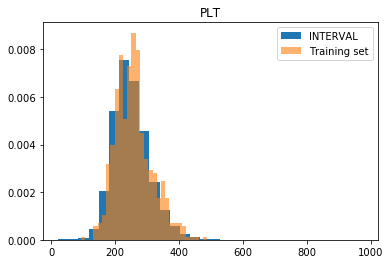

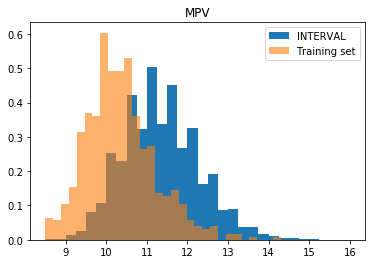

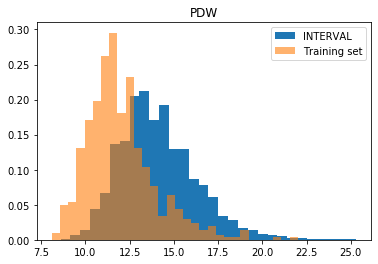

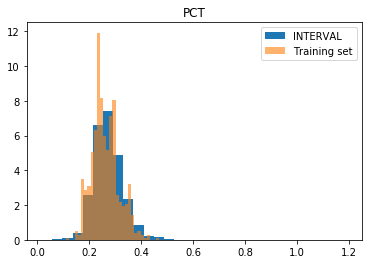

In [47]:
for c in ["PLT", "MPV", "PDW", "PCT"]:
    plt.figure()
    plt.title(c)
    plt.hist(sys_pheno_df[c],bins=30,density=True, label="INTERVAL")
    d = c
    if c == "PLT":
        d += "_count"
    plt.hist(sys_phen_train[d],bins=30,density=True,alpha=.6,label="Training set")
    plt.legend()

# Load scattergrams

In [16]:
sysmex_dir = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_HAAS"
files = glob.glob("%s/*/SCT/PLTF*.csv" % sysmex_dir)
sys_pheno_df = pd.read_hdf("%s/sys_pheno_df.hdf" % export_folder)
#sub_sample_size = 1000

In [17]:
sys_pheno_df.Instrument.value_counts()

XN-10^11036    19471
XN-10^11041    18232
Name: Instrument, dtype: int64

In [18]:
#sel_files = np.random.choice(sys_pheno_df.FileName.tolist(),1000)
#sel_files = sys_pheno_df.FileName.tolist()[:1000]
sel_files = sys_pheno_df.FileName.tolist()

In [19]:
good_files = [f for f in files if f.split("PLTF_")[-1].split(".116")[0] + ".116" in sel_files]

In [7]:
print(len(good_files))

37708


In [8]:
def summarize_sysmex_file(f):
    file_name = f.split("PLTF_")[-1].split(".116")[0] + ".116"
    
    df = pd.read_csv(f,engine="python")[["FSC", "SSC", "SFL"]]
    # Conditions taken from the preprocessing.py file
    df = df.loc[df.SFL > 0.1]
    df = df.loc[df.SFL <= 220]
    df = df.loc[df.FSC <= 200]
    machine = f.split("/")[10]
    
    df = df.mean(axis=0)
    df["machine"] = machine
    df["file_name"] = file_name
    return df

# Adjust cell-level data

In [10]:
dfs = []
pool = Pool(24)
for df in tqdm(pool.imap_unordered(summarize_sysmex_file, good_files),total=len(good_files)):
    dfs.append(df)

100%|██████████| 984/984 [00:10<00:00, 94.66it/s] 
Process ForkPoolWorker-18:
Process ForkPoolWorker-21:
Process ForkPoolWorker-16:
Process ForkPoolWorker-23:
Process ForkPoolWorker-24:
Process ForkPoolWorker-17:
Process ForkPoolWorker-20:
Process ForkPoolWorker-7:
Process ForkPoolWorker-5:
Process ForkPoolWorker-6:
Process ForkPoolWorker-19:
Process ForkPoolWorker-14:
Process ForkPoolWorker-9:
Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Process ForkPoolWorker-4:
Process ForkPoolWorker-15:
Process ForkPoolWorker-8:
Process ForkPoolWorker-22:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last)

  File "/home/hv270/platelets/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home

  File "/home/hv270/platelets/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


In [31]:
sys_df = pd.concat(dfs,axis=1).T
sys_df.to_csv("%s/sys_df.csv" % export_folder)

In [32]:
sys_df_full = pd.read_csv("%s/sys_df.csv" % export_folder,engine="python")

## By time

In [33]:
# One line per donor

In [34]:
sys_df_full.head()

,Unnamed: 0,FSC,SSC,SFL,machine,file_name
0,0,52.149491,34.902847,79.347532,XN-10^11041,[XN-10^11041][00-15_5][20150217_094335][ ...
1,1,56.290149,45.909069,77.482376,XN-10^11041,[XN-10^11041][00-15_5][20141126_094810][ ...
2,2,61.826405,50.058232,84.040361,XN-10^11041,[XN-10^11041][00-15_5][20141007_125226][ ...
3,3,69.748763,46.796732,86.054814,XN-10^11041,[XN-10^11041][00-13_16][20130628_103919][ ...
4,4,54.075041,44.747160,77.170881,XN-10^11041,[XN-10^11041][00-15_5][20140816_090428][ ...


In [35]:
sys_df_full[["FSC", "SSC", "SFL"]].mean()

FSC    59.733398
SSC    40.346200
SFL    79.902942
dtype: float64

======= XN-10^11041 ======
             FSC       SSC       SFL
cohort                              
F12     0.993593  1.000959  0.999307
F14     0.991590  0.999948  0.998459
F16     0.988849  0.994445  0.998142
FBL     0.995281  1.000025  1.000331
M08     1.009293  1.002202  1.000901
M10     1.009692  1.003778  1.003660
M12     1.005277  1.000500  1.000445
MBL     1.004797  0.999462  0.999342
======= XN-10^11036 ======
             FSC       SSC       SFL
cohort                              
F12     0.995184  1.000020  0.999387
F14     0.991766  0.996096  0.998606
F16     0.994727  1.001905  0.999927
FBL     0.994221  0.997874  0.999976
M08     1.008908  1.003016  1.001701
M10     1.001517  0.998796  0.998986
M12     1.006304  1.003734  1.001847
MBL     1.005872  1.001214  0.999855


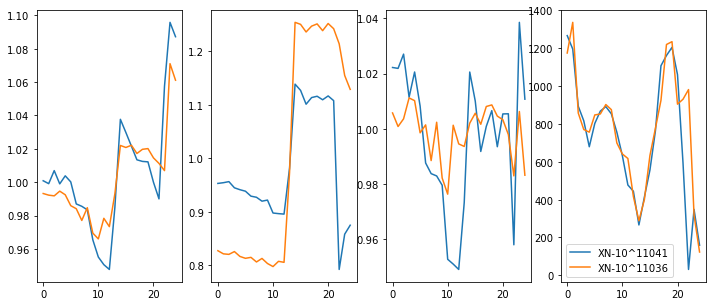

In [36]:
sys_dfs_adj = []
fig = plt.figure(figsize=(12,5))
ax_sfl = fig.add_subplot(141)
ax_ssc = fig.add_subplot(142)
ax_fsc = fig.add_subplot(143)
ax_count = fig.add_subplot(144) 

for machine in sys_df_full.machine.unique():
    print("======= %s ======" % machine)
    
    sys_df = pd.merge(sys_pheno_df[["DateTime","FileName","cohort"]], 
                      sys_df_full.loc[sys_df_full.machine == machine], 
                      left_on="FileName", right_on="file_name",how="inner")
    sys_df["months"] = (sys_df.DateTime - sys_df.DateTime.min() ).dt.days // 30
    ratio_by_month = sys_df.groupby("months")[["FSC","SSC", "SFL"]].mean() / sys_df[["FSC","SSC", "SFL"]].mean()
    count_by_month = sys_df.groupby("months")[["FSC","SSC", "SFL"]].count()
    
    ax_sfl.plot(ratio_by_month["SFL"],label=machine)
    ax_ssc.plot(ratio_by_month["SSC"],label=machine)
    ax_fsc.plot(ratio_by_month["FSC"],label=machine)
    ax_count.plot(count_by_month["FSC"],label=machine)
    
    sys_df_adj = sys_df[ratio_by_month.columns] / pd.merge(sys_df[["months"]], 
                                                        ratio_by_month, 
                                                        right_index=True,
                                                        left_on="months",how="left")[ratio_by_month.columns]
    sys_df[[c+"_RAW" for c in sys_df_adj.columns]] = sys_df[sys_df_adj.columns]
    sys_df[sys_df_adj.columns] = sys_df_adj
    
    ratio_by_RA = sys_df.groupby("cohort")[["FSC","SSC", "SFL"]].mean() / sys_df[["FSC","SSC", "SFL"]].mean()
    print(ratio_by_RA)
    sys_df_adj = sys_df[ratio_by_RA.columns] / pd.merge(sys_df[["cohort"]], 
                                                        ratio_by_RA, 
                                                        right_index=True,
                                                        left_on="cohort",how="left")[ratio_by_RA.columns]
    sys_df[sys_df_adj.columns] = sys_df_adj
    sys_dfs_adj.append(sys_df)
plt.legend()

In [37]:
sys_df = pd.concat(sys_dfs_adj,axis=0)

## Then, adjust by machine

In [38]:
ratio_machine = sys_df.groupby("machine")[["FSC","SSC","SFL"]].mean() / sys_df[["FSC","SSC","SFL"]].mean()
print(ratio_machine)
sys_df_adj = sys_df[ratio_machine.columns] / pd.merge(sys_df[["machine"]], ratio_machine, right_index=True,left_on="machine",how="left")[ratio_machine.columns]
sys_df[ratio_machine.columns] = sys_df_adj[ratio_machine.columns]

                  FSC       SSC       SFL
machine                                  
XN-10^11036  1.008743  0.918169  1.021959
XN-10^11041  0.990663  1.087396  0.976548


In [39]:
sys_df.head()

,DateTime,FileName,cohort,Unnamed: 0,FSC,SSC,SFL,machine,file_name,months,FSC_RAW,SSC_RAW,SFL_RAW
0,2013-03-01 10:19:44,[XN-10^11041][00-11_8][20130301_101944][ ...,MBL,2611,56.173948,37.234636,76.142138,XN-10^11041,[XN-10^11041][00-11_8][20130301_101944][ ...,0,57.157161,38.562735,74.370624
1,2013-03-01 10:21:00,[XN-10^11041][00-11_8][20130301_102100][ ...,FBL,10301,63.750745,42.352482,81.013957,XN-10^11041,[XN-10^11041][00-11_8][20130301_102100][ ...,0,64.252266,43.887792,79.207444
2,2013-03-01 10:22:16,[XN-10^11041][00-11_8][20130301_102216][ ...,MBL,165,53.773095,37.249192,73.449274,XN-10^11041,[XN-10^11041][00-11_8][20130301_102216][ ...,0,54.714286,38.577810,71.740413
3,2013-03-01 10:23:33,[XN-10^11041][00-11_8][20130301_102333][ ...,FBL,13726,57.878832,37.418064,79.240717,XN-10^11041,[XN-10^11041][00-11_8][20130301_102333][ ...,0,58.334160,38.774498,77.473745
4,2013-03-01 10:24:49,[XN-10^11041][00-11_8][20130301_102449][ ...,FBL,10798,64.232376,42.556637,84.145479,XN-10^11041,[XN-10^11041][00-11_8][20130301_102449][ ...,0,64.737686,44.099348,82.269136


## Finally, make it stick to training means

In [40]:
sys_df = sys_df.rename(columns={"FSC":"Forward Scatter Signal", 
                        "SSC":"Side Scatter Signal", 
                        "SFL":"Side Fluorescence Signal"})
signals = ["Side Fluorescence Signal","Forward Scatter Signal","Side Scatter Signal"]

In [41]:
sys_df_adjusted= pd.read_hdf("%s/sys_df_adjusted.hdf" % training_data)
ratio = sys_df[signals].mean() / sys_df_adjusted.groupby("ID")[signals].mean().mean()

In [42]:
ratio[signals]

Side Fluorescence Signal    0.992584
Forward Scatter Signal      0.863515
Side Scatter Signal         0.838593
dtype: float64

In [43]:
sys_df[signals] = sys_df[signals] / ratio

In [44]:
sys_df[signals]

,Side Fluorescence Signal,Forward Scatter Signal,Side Scatter Signal
0,76.710992,65.052637,44.401331
1,81.619208,73.826999,50.504229
2,73.998010,62.272311,44.418688
3,79.832721,67.026989,44.620064
4,84.774125,74.384755,50.747678
5,78.739486,64.270133,47.805545
6,92.785534,82.314429,55.538312
7,81.747733,76.106260,56.529387
8,76.873049,63.847958,44.749646
9,82.469561,75.429819,50.868567


In [45]:
sys_df_adjusted.head(3)

,Side Fluorescence Signal,Forward Scatter Signal,Side Scatter Signal,ID,exp,PLT
17086147,85.0,91.0,53.0,C0WXJ5,wb,1
17086148,135.0,135.0,102.0,C0WXJ5,wb,1
17086149,77.0,69.0,52.0,C0WXJ5,wb,1


In [46]:
sys_df[signals].mean()

Side Fluorescence Signal    80.499893
Forward Scatter Signal      69.174683
Side Scatter Signal         48.111790
dtype: float64

In [47]:
sys_df_adjusted.groupby("ID")[signals].mean().mean()

Side Fluorescence Signal    80.499893
Forward Scatter Signal      69.174683
Side Scatter Signal         48.111790
dtype: float32

In [48]:
sys_df.to_hdf("%s/adjustment_constants.hdf" % export_folder,key="constants")

# Read files and compute features

In [5]:
#normalizer = pickle.load(open("%s/sysmex_norm_wb.pkl" % training_data,"rb"))
#re-normalize Sysmex scattergrams
normalizer = QuantileTransformer(output_distribution="normal")
pca = pickle.load(open("%s/sysmex_pca_wb.pkl" % training_data,"rb"))
f_scaler = pickle.load(open("%s/sysmex_f_scaler_wb.pkl" % training_data,"rb"))
sys_df_train= pd.read_hdf("%s/sys_df.hdf" % training_data)
sys_df_adjusted= pd.read_hdf("%s/sys_df_adjusted.hdf" % training_data)
sys_df = pd.read_hdf("%s/adjustment_constants.hdf" % export_folder)
sys_pheno_df = pd.read_hdf("%s/sys_pheno_df.hdf" % export_folder)

In [6]:
sys_df.head(2)

,DateTime,FileName,cohort,Unnamed: 0,Forward Scatter Signal,Side Scatter Signal,Side Fluorescence Signal,machine,file_name,months,FSC_RAW,SSC_RAW,SFL_RAW
0,2013-03-01 10:19:44,[XN-10^11041][00-11_8][20130301_101944][ ...,MBL,2611,65.052637,44.401331,76.710992,XN-10^11041,[XN-10^11041][00-11_8][20130301_101944][ ...,0,57.157161,38.562735,74.370624
1,2013-03-01 10:21:00,[XN-10^11041][00-11_8][20130301_102100][ ...,FBL,10301,73.826999,50.504229,81.619208,XN-10^11041,[XN-10^11041][00-11_8][20130301_102100][ ...,0,64.252266,43.887792,79.207444


In [7]:
sys_df.shape

(37708, 13)

In [8]:
mpv = sys_pheno_df.groupby("FileName")["MPV"].mean()
plt_count = sys_pheno_df.groupby("FileName")["PLT"].mean()
pdw = sys_pheno_df.groupby("FileName")["PDW"].mean()
pct = sys_pheno_df.groupby("FileName")["PCT"].mean()

## Check sysmex phenotypes

In [9]:
print(mpv.mean())
print(plt_count.mean())
print(pdw.mean())
print(pct.mean())

11.329001487937083
249.73166591517915
14.118883515782763
0.2758930279519609


In [10]:
10.371948998178508
256.8251366120219
12.049544626593807
0.26098360655737707

0.26098360655737707

## Read and extract platelets

In [56]:
sys_pheno_df.Instrument.value_counts()

XN-10^11036    19471
XN-10^11041    18232
Name: Instrument, dtype: int64

In [57]:
sys_pheno_df.head()

,valid_id,FileName,SampleNo,Instrument,DateTime,months,cohort,PLT,MPV,PDW,PCT
0,1090916.0,[XN-10^11041][00-11_8][20130301_101944][ ...,INT_116_6580100,XN-10^11041,2013-03-01 10:19:44,0,MBL,212.0,11.0,13.8,0.22
2,1111731.0,[XN-10^11041][00-11_8][20130301_102100][ ...,INT_116_6580000,XN-10^11041,2013-03-01 10:21:00,0,FBL,235.0,11.4,14.9,0.27
4,1070498.0,[XN-10^11041][00-11_8][20130301_102216][ ...,INT_116_2129800,XN-10^11041,2013-03-01 10:22:16,0,MBL,196.0,10.1,12.1,0.20
6,1042358.0,[XN-10^11041][00-11_8][20130301_102333][ ...,INT_116_4555900,XN-10^11041,2013-03-01 10:23:33,0,FBL,143.0,11.9,13.0,0.15
7,1111391.0,[XN-10^11041][00-11_8][20130301_102449][ ...,INT_116_4555800,XN-10^11041,2013-03-01 10:24:49,0,FBL,197.0,12.3,16.3,0.25


In [11]:
def tag_platelets_debug(df, export_folder, expected_counts = None):
    """
    This is where platelets are tagged
    A few cells are discarded by hand using simple gating, partly to reduce
    unnecessary computing of clusters.
    The rest is tagged using DBSCAN
    :param df: all Sysmex measurements
    :return: A dataframe containing all measurements and a column PLT
    equal to 1 if the cell is a platelet
    """

    df["PLT"] = 0
    n = 0
    ids = df.ID.unique().tolist()
    ids = np.random.permutation(ids)

    exps = df.exp.unique()
    for exp in exps:
        if not os.path.exists("%s/clustering_train/%s" % (export_folder,exp)):
            os.makedirs("%s/clustering_train/%s" % (export_folder,exp))

    for ID in ids:
        n += 1
        
        for exp in exps:
            cond = (df.exp == exp) & (df.ID == ID)  #& cond_0
            X = df.loc[cond][['Side Fluorescence Signal', 'Forward Scatter Signal']].values
            expected = None
            if expected_counts is not None:
                expected = expected_counts.loc[ID]
            PLT = tag_platelets_of_assay_debug(X.copy(), expected)
            df.loc[cond, "PLT"] = PLT.values
            #if exp == "wb":
            #    fig = plt.figure()
            #    ax = fig.add_subplot(111)
            #    ax.scatter(df.loc[cond,"Side Fluorescence Signal"],
            #        df.loc[cond,"Forward Scatter Signal"],
            #        c=df.loc[cond,"PLT"],s=1)
            #    ax.set_title("%s %s" % (ID,exp))
            #    plt.savefig("%s/clustering_train/%s/%s.png" % (export_folder,exp,ID))

    #print("%.2f  of cells are platelets" % (df["PLT"].mean()))

    return df

In [12]:
def polygon_with_offset(offset):
    alpha = ((120+.6*offset) - (25+ .5*offset)) / (85 - 25)
    
    p = np.array([[22,25,30,85 ,140,200,200,80,50,22],
                  [5 + .3*offset ,25+ .5*offset,max(35+.5*offset,25+.5*offset + alpha*5),120+.6*offset,180+.6*offset,220,170,20,0,5+ .3*offset]])
    #p[0] -= offset
    return p.T

In [13]:
def tag_platelets_of_assay_debug(X, expected):
    #print("Using polygon")
    is_plt = {}
    plt_count = np.zeros(30)
    offsets = np.linspace(-50,35,len(plt_count))
    for i, offset in enumerate(offsets):
        polygon = polygon_with_offset(offset)
        path = mplPath.Path(polygon)
        is_plt[i] =  1*pd.Series([(path.contains_point(pnt,radius=0.01) or path.contains_point(pnt,radius=-0.01)) for pnt in X])
        plt_count[i] = is_plt[i].sum()
    diff = np.diff(plt_count) # n of cells in the slice
    w = np.array([1,2,3,2,1])
    diff[2:-2] = np.convolve(diff, w / np.sum(w),mode="valid")
    
    diff2 = diff[1:]/diff[:-1]
    
    d_min_cells = np.argmin(diff)
    d_max_cells = np.argmax(diff)
    
    try:
        try:
            d_valid_diff = np.min(np.where(diff2[d_max_cells:] < 0.97)[0]) + d_max_cells
            d_max_diff = np.min(np.where(diff2[d_valid_diff:] > 0.97)[0]) + d_valid_diff
        except:
            d_max_diff = d_min_cells
            
        try:
            d = np.max(np.where(diff[:d_max_diff] > 1.7*diff[d_max_diff])[0]) # Différence relative
            #d = max(d, np.max(np.where(diff[:d_max_diff] > diff[d_max_diff] + 0.1*np.max(diff))[0])) # Différence absolue
        except:
            d = d_max_diff
        #print(d_min_cells,d_max_diff, d)
        

    except:
    
        plt.figure()
        plt.title("Diff")
        plt.plot(diff)
        plt.figure()
        plt.title("Diff2")
        plt.plot(diff2)
        raise
    """
    plt.figure()
    plt.scatter(X[:,0],X[:,1],s=.1)
    plt.plot(polygon_with_offset(offsets[d_min_cells])[:,0],
             polygon_with_offset(offsets[d_min_cells])[:,1], label="Min cells")
    plt.plot(polygon_with_offset(offsets[d_max_diff])[:,0],
             polygon_with_offset(offsets[d_max_diff])[:,1], label="rebounce")
    plt.plot(polygon_with_offset(offsets[d])[:,0],
             polygon_with_offset(offsets[d])[:,1], label="chosen = %d" % d)
    plt.legend()
    """
    return is_plt[int(d)]
    

In [14]:
def extract_platelets_debug(f):
    
    file_name = f.split("PLTF_")[-1].split(".116")[0] + ".116"
    df = pd.read_csv(f,engine="python")[["FSC", "SSC", "SFL"]]
    # Conditions taken from the preprocessing.py file
    df = df.loc[df.SFL > 0.1]
    df = df.loc[df.SFL <= 220]
    df = df.loc[df.FSC <= 200]
    if df.shape[0] < 1000:
        return None
    machine = f.split("/")[10]
    
    df["machine"] = machine
    df["file_name"] = file_name
    
    cond = (sys_df.file_name == file_name)
    
    if cond.sum() != 1:
        print("Strange %s" % file_name)
        return None
     
    df["SFL"] = df["SFL"] * sys_df.loc[cond,"Side Fluorescence Signal"].iloc[0] / df["SFL"].mean()
    df["FSC"] = df["FSC"] * sys_df.loc[cond,"Forward Scatter Signal"].iloc[0] / df["FSC"].mean() 
    df["SSC"] = df["SSC"] * sys_df.loc[cond,"Side Scatter Signal"].iloc[0] / df["SSC"].mean() 
    df = df.rename(columns={"SFL":"Side Fluorescence Signal", 
                            "FSC":"Forward Scatter Signal",
                            "SSC":"Side Scatter Signal"})
    df["ID"] = file_name
    df["exp"] = "wb"
    
    df = tag_platelets_debug(df, 
                       "%s/tagged_platelets/" % export_folder, 
                       expected_counts=sys_pheno_df.groupby("FileName")["PLT"].first()*80) 
    # 80 is the scaling factor between PLT count and total number of platelets
    
    return df

In [ ]:
#gfiles = [good_files[i] for i in list(np.random.choice(len(good_files),sub_sample_size))]
gfiles = good_files

28 15 12
27 18 13
27 15 10
28 18 13
27 24 23
27 16 12
28 15 12
27 14 10
27 12 9
28 23 22
27 23 21
28 15 5
26 20 15
27 18 14
27 17 13
27 20 15
28 24 21
28 16 11
26 22 21
26 25 24


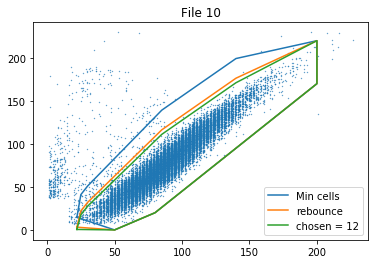

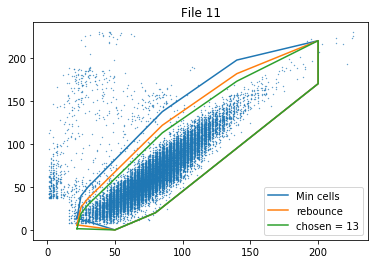

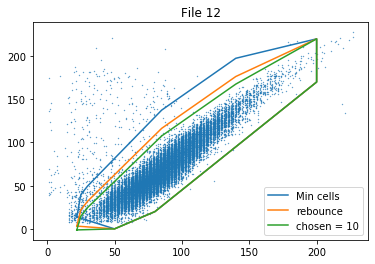

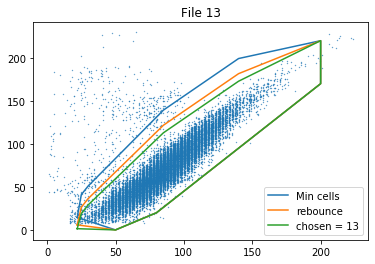

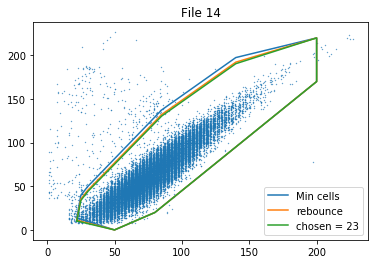

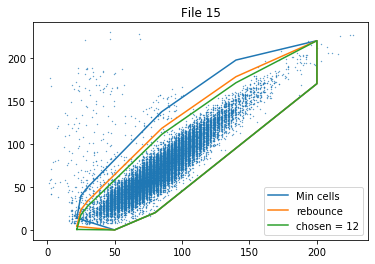

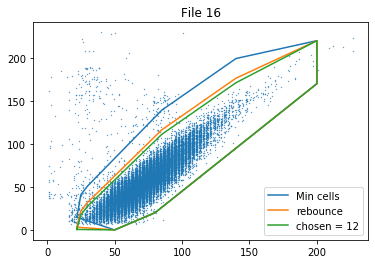

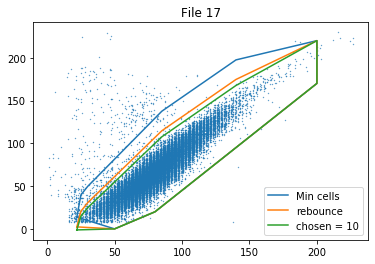

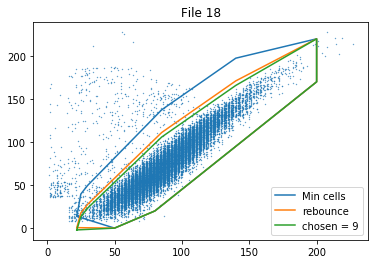

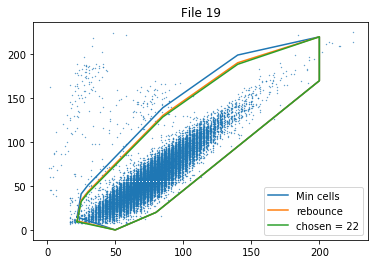

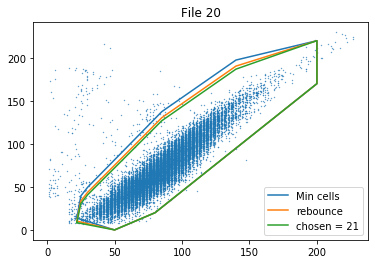

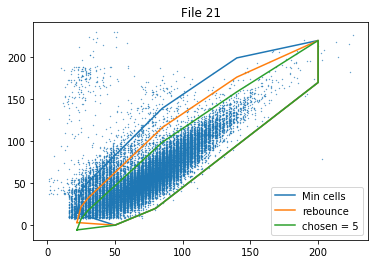

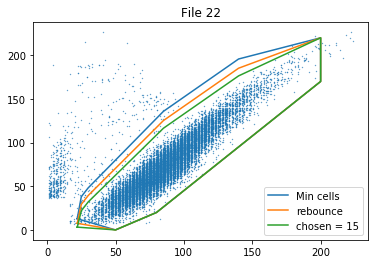

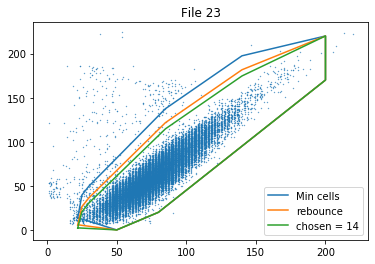

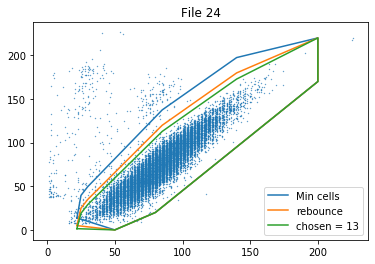

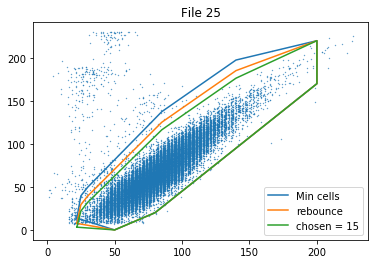

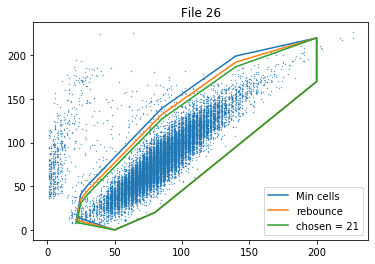

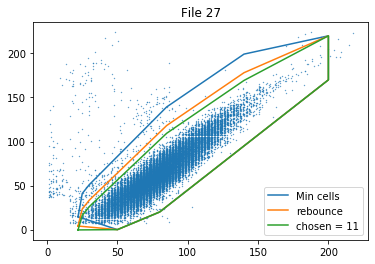

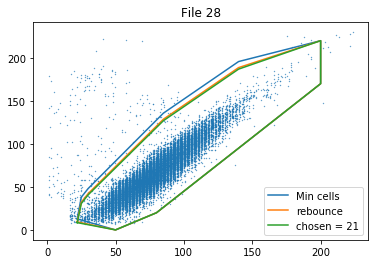

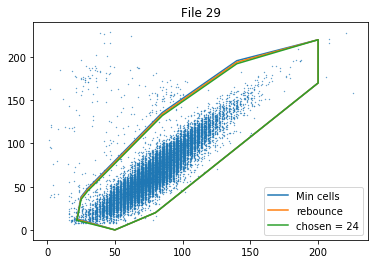

In [58]:
for i in range(10,30):
    test = extract_platelets_debug(gfiles[i])
    plt.title("File %d" % i)

In [ ]:
plt_dfs = []
pool = Pool(24)
for plt_df in tqdm(pool.imap_unordered(extract_platelets_debug, gfiles),total=len(gfiles)):
    if plt_df is not None:
        plt_dfs.append(plt_df.sample(500,replace=True))
    else:
        print("___________ Returned None __________")

  3%|▎         | 1200/37708 [02:15<1:01:23,  9.91it/s]

In [ ]:
plt_df = pd.concat(plt_dfs, axis=0)

In [ ]:
plt_df.groupby("ID")["Forward Scatter Signal"].mean().mean()

In [ ]:
sys_df_adjusted.groupby("ID")["Forward Scatter Signal"].mean().mean()

In [ ]:
plt.scatter(plt_df.iloc[:int(1e5)]["Side Fluorescence Signal"], 
            plt_df.iloc[:int(1e5)]["Forward Scatter Signal"],s=1.,alpha=0.6,label="INTERVAL")
plt.scatter(sys_df_adjusted.iloc[:int(1e5)]["Side Fluorescence Signal"], 
            sys_df_adjusted.iloc[:int(1e5)]["Forward Scatter Signal"],s=1.,alpha=0.6,label="TRAINING")


plt.legend()
pass

In [ ]:
plt.hist([d.PLT.sum() for d in plt_dfs],density=True,label="INTERVAL",alpha=0.7,bins=20)
plt.hist(sys_df_train.groupby("ID")["PLT"].sum(),density=True,label="Training",alpha=0.7,bins=20)
plt.xlabel("PLT count")
plt.legend()
pass

## Check platelets clustering

In [55]:
plt_df.machine.value_counts()

XN-10^11036    11009346
XN-10^11041    10153850
Name: machine, dtype: int64

In [56]:
comp = pd.merge(plt_df.groupby("file_name")["PLT"].sum(), sys_pheno_df,left_index=True,right_on="FileName",how="inner")

In [57]:
comp.Instrument.unique()

array(['XN-10^11036', 'XN-10^11041'], dtype=object)

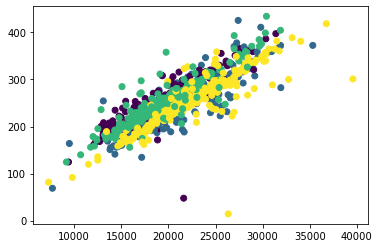

In [58]:
plt.scatter(comp["PLT_x"],comp["PLT_y"],c = comp.cohort.str.contains("F")*1 + (comp.Instrument == "XN-10^11041")*2)

In [28]:
sfiles = plt_df.file_name.unique().tolist()
sub_sample_plt_df = plt_df.loc[plt_df.file_name.isin(sfiles[-10:])]

In [61]:
comp.loc[comp.PLT_y < 50]

,PLT_x,valid_id,FileName,SampleNo,Instrument,DateTime,months,cohort,PLT_y,MPV,PDW,PCT
38990,21616,1057600.0,[XN-10^11036][00-15_5][20140724_104158][ ...,INT_116_5309800,XN-10^11036,2014-07-24 10:41:58,17,M10,47.695960,11.500289,14.631044,0.340772
35225,26344,1100503.0,[XN-10^11041][00-15_5][20140509_100757][ ...,INT_116_2747000,XN-10^11041,2014-05-09 10:07:57,14,F12,14.307455,11.314900,13.178765,0.005046


2


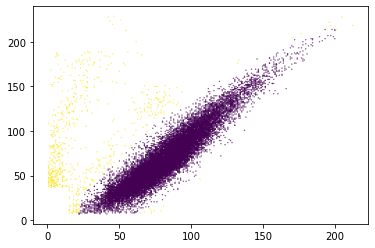

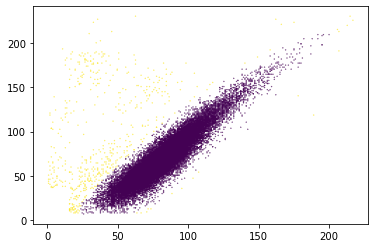

In [62]:
suspect_filenames = comp.loc[comp.PLT_y < 50].FileName.tolist()
print(len(suspect_filenames))
for name in suspect_filenames:
    plt.figure()
    suspect_plt = plt_df.loc[plt_df.file_name == name]
    plt.scatter(suspect_plt["Side Fluorescence Signal"], suspect_plt["Forward Scatter Signal"], c=~suspect_plt["PLT"],s=.1)

## Compare scattergrams with training

In [ ]:
for i in range(len(selected_columns)):
    plt.figure()
    plt.hist(plt_df.loc[plt_df.PLT == 1,selected_columns[i]],bins=100,density=True, label="Interval",alpha=0.8)
    #plt.hist(sys_df_adjusted.loc[sys_df_adjusted.PLT == 1,selected_columns[i]],bins=100,density=True, label="Adj.Training",alpha=0.8)
    plt.hist(sys_df_train.loc[sys_df_train.PLT == 1,selected_columns[i]],bins=100,density=True, alpha=0.8, label="Training")
    plt.tight_layout()
    plt.legend()
    plt.title(selected_columns[i])
    pass

In [ ]:

plt.scatter(plt_df.loc[plt_df.PLT == 1,"Side Fluorescence Signal"].sample(int(1e5), random_state=0, replace=True), 
            plt_df.loc[plt_df.PLT == 1,"Forward Scatter Signal"].sample(int(1e5), random_state=0, replace=True),s=1.,alpha=0.6,label="INTERVAL")
plt.scatter(sys_df_train.loc[sys_df_train.PLT == 1,"Side Fluorescence Signal"].sample(int(1e5), random_state=0), 
            sys_df_train.loc[sys_df_train.PLT == 1,"Forward Scatter Signal"].sample(int(1e5), random_state=0),s=1.,alpha=0.6,label="TRAINING")
plt.legend()
plt.xlabel("Side Fluorescence")
plt.ylabel("Forward Scatter")
pass

In [ ]:
plt.scatter(plt_df.loc[plt_df.PLT == 1,"Side Fluorescence Signal"].sample(int(1e5), random_state=0, replace=True), 
            plt_df.loc[plt_df.PLT == 1,"Side Scatter Signal"].sample(int(1e5), random_state=0, replace=True),s=1.,alpha=0.6,label="INTERVAL")
plt.scatter(sys_df_train.loc[sys_df_train.PLT == 1,"Side Fluorescence Signal"].sample(int(1e5), random_state=0), 
            sys_df_train.loc[sys_df_train.PLT == 1,"Side Scatter Signal"].sample(int(1e5), random_state=0),s=1.,alpha=0.6,label="TRAINING")
plt.legend()
pass

## Fix tail shape

We interpolate FSC and SSC mean values at bins of SFL, and make the means stick between INTERVAL and training by changing INTERVAL values

In [ ]:
from scipy.interpolate import interp1d

In [ ]:
sub_training = pd.concat([sys_df_train.loc[(sys_df_train.ID == ID) & (sys_df_train.PLT == 1)].sample(500) for ID in sys_df_train.ID.unique().tolist()],axis=0)
#sub_interval = plt_df.loc[plt_df.PLT == 1].sample(int(1e6))
sub_interval = pd.concat([d.loc[d.PLT == 1].sample(500,replace=True) for d in plt_dfs],axis=0).copy()

In [ ]:
sfl_points = np.linspace(sub_training["Side Fluorescence Signal"].min(), 
                       sub_training["Side Fluorescence Signal"].max(),
                       20,endpoint=True)
bin_size = (sub_training["Side Fluorescence Signal"].max() - sub_training["Side Fluorescence Signal"].min()) / 19

train_means_by_bin = {}
interval_means_by_bin = {}
for i in range(20):
    train_means_by_bin[i] = sub_training.loc[(sub_training["Side Fluorescence Signal"] > sfl_points[i] - 0.5*bin_size) & \
                     (sub_training["Side Fluorescence Signal"] <= sfl_points[i] + 0.5*bin_size),
                     ["Side Scatter Signal", "Forward Scatter Signal"]].mean()
    interval_means_by_bin[i] = sub_interval.loc[(sub_interval["Side Fluorescence Signal"] > sfl_points[i] - 0.5*bin_size) & \
                     (sub_interval["Side Fluorescence Signal"] <= sfl_points[i] + 0.5*bin_size),
                     ["Side Scatter Signal", "Forward Scatter Signal"]].mean()



In [ ]:
offset_ssc = interp1d(sfl_points,[train_means_by_bin[i]["Side Scatter Signal"] - \
                                  interval_means_by_bin[i]["Side Scatter Signal"] for i in range(20)], fill_value="extrapolate")
offset_fsc = interp1d(sfl_points,[train_means_by_bin[i]["Forward Scatter Signal"] - \
                                  interval_means_by_bin[i]["Forward Scatter Signal"] for i in range(20)], fill_value="extrapolate")

In [ ]:
plt.plot(sfl_points, offset_ssc(sfl_points))
plt.plot(sfl_points, offset_fsc(sfl_points))

In [ ]:
adj_interval = sub_interval.copy()
adj_interval["Side Scatter Signal"] = adj_interval["Side Scatter Signal"] + offset_ssc(adj_interval["Side Fluorescence Signal"])
adj_interval["Forward Scatter Signal"] = adj_interval["Forward Scatter Signal"] + offset_fsc(adj_interval["Side Fluorescence Signal"])

In [ ]:
plt.scatter(adj_interval["Side Fluorescence Signal"].sample(100000,random_state=0, replace=True), adj_interval["Forward Scatter Signal"].sample(100000,random_state=0, replace=True), s=1., label="Adjusted interval")
plt.scatter(sub_training["Side Fluorescence Signal"].sample(100000,random_state=0, replace=True), sub_training["Forward Scatter Signal"].sample(100000,random_state=0, replace=True), s=1., alpha = 0.6, label="Training")
plt.xlabel("Side Fluorescence")
plt.ylabel("Forward Scatter")
plt.legend()

## Fit scaler

In [ ]:
plt_df_subsample = pd.concat([d.loc[d.PLT == 1].sample(500,replace=True) for d in plt_dfs], axis=0)
plt_df_subsample["Side Scatter Signal"] = plt_df_subsample["Side Scatter Signal"] + \
                                        offset_ssc(plt_df_subsample["Side Fluorescence Signal"])
plt_df_subsample["Forward Scatter Signal"] = plt_df_subsample["Forward Scatter Signal"] +  \
                                        offset_fsc(plt_df_subsample["Side Fluorescence Signal"])

In [ ]:
normalizer.fit(plt_df_subsample[selected_columns])

## Extract features

In [75]:
f_scaler

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

In [ ]:
def extract_features(file):
    """
    Re-do everything that was done above, and compute features
    """
    df = extract_platelets_debug(file)
    if df is not None:
        assert df.PLT.sum() > 0
    else:
        return None, None
    df["Side Scatter Signal"] = df["Side Scatter Signal"] + offset_ssc(df["Side Fluorescence Signal"])
    df["Forward Scatter Signal"] = df["Forward Scatter Signal"] + offset_fsc(df["Side Fluorescence Signal"])
    X = df.loc[df.PLT == 1,selected_columns]
    X = normalizer.transform(X)
    X = pca.transform(X)
    if X.shape[0] <= 10:
        return None, None
    X = pd.DataFrame(data=X,index=df.loc[df.PLT == 1].index)
    X["ID"] = df.loc[df.PLT == 1,"ID"]
    features = get_features_per_ID(X,mpv, plt_count, pdw, pct,0,0)
    if features.shape[0] == 0:
        print("Strange, features had no row...")
        print(features)
        print(X)
        return None, None
    features[features.columns] = f_scaler.transform(features)
    return features.copy(), X

In [ ]:
feature_dfs = []
Xs = []
pool = Pool(24)
for feature_df, X in tqdm(pool.imap_unordered(extract_features, gfiles),total=len(gfiles)):
    if feature_df is not None:
        feature_dfs.append(feature_df)
        Xs.append(X)
    else:
        print("____________ Couldn't compute features _________")

## Check PCA-transformed platelets

In [ ]:
X = pd.concat(Xs,axis=0).sample(int(1e6))

In [79]:
X.head()

,0,1,ID
14506,1.328120,1.142203,[XN-10^11041][00-15_5][20141028_092944][ ...
3437,-1.742475,0.870338,[XN-10^11041][00-15_5][20140613_104449][ ...
899,-1.200037,0.665442,[XN-10^11036][00-15_5][20141015_100216][ ...
5451,-0.321387,-0.886214,[XN-10^11036][00-15_5][20141029_103425][ ...
15520,2.732840,0.420437,[XN-10^11036][00-13_16][20130619_105754][ ...


In [ ]:
plt.scatter(X[0],X[1],s=.01)

In [81]:
X[[0,1]].mean()

0   -0.166985
1    0.014418
dtype: float64

## Check features

In [ ]:
features_train = pd.read_hdf("%s/features.hdf" % training_data,key="features")

In [83]:
len(feature_dfs)

959

In [ ]:
features = pd.concat(feature_dfs,axis=0)

In [ ]:
#features[features.columns] = RobustScaler().fit_transform(features)

In [ ]:
#features.rename(columns={"PLT_count":"PLT"},inplace=True)
features = features[~features.index.duplicated(keep=False)]
sys_cols = ["PLT", "MPV", "PDW", "PCT"]
for c in sys_cols:
    features[c] = RobustScaler().fit_transform(features[[c]])

In [ ]:
for f in features.columns:
    plt.figure()
    plt.hist(features[f],bins=20,density=True,alpha=0.7,label="interval")
    plt.hist(features_train[f+"_wb"],bins=20,density=True,alpha=0.7,label="train")
    plt.title(f)
    plt.legend()

In [3]:
features = pd.read_hdf("%s/interval_features.hdf" % export_folder, key="features")

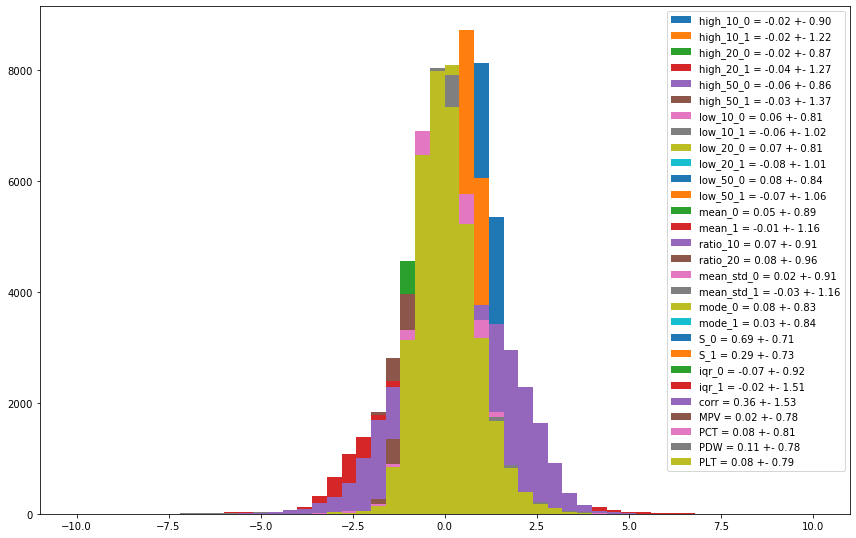

In [10]:
plt.figure(figsize=(12,8))
for f in features.columns:
    plt.hist(features[f],label="%s = %.2f +- %.2f" % (f, features[f].mean(),features[f].std()),range=(-10,10),bins=50)
plt.legend()
plt.tight_layout()

Looks good !

## Force scale features

In [11]:
for c in features.columns:
    features[c] = RobustScaler().fit_transform(features[[c]])

In [12]:
features.to_hdf("%s/interval_features.hdf" % export_folder, key="features")

In [13]:
features_train.mean()

NameError: name 'features_train' is not defined

In [14]:
features.mean()

high_10_0     0.022893
high_10_1     0.038712
high_20_0     0.027828
high_20_1     0.039279
high_50_0     0.035222
high_50_1     0.035281
low_10_0      0.006716
low_10_1     -0.017370
low_20_0      0.006721
low_20_1     -0.023298
low_50_0      0.016309
low_50_1     -0.035032
mean_0        0.006413
mean_1        0.006373
ratio_10      0.029682
ratio_20      0.030576
mean_std_0   -0.015137
mean_std_1   -0.003827
mode_0       -0.067740
mode_1        0.007965
S_0          -0.029706
S_1          -0.080789
iqr_0         0.063447
iqr_1         0.000181
corr         -0.042134
MPV           0.024271
PCT           0.083167
PDW           0.113934
PLT           0.080388
dtype: float64

# Predict ! 

In [4]:
features = pd.read_hdf("%s/interval_features.hdf" % export_folder, key="features")
pred_files = glob.glob("%s/trained_predictors/*.pkl" % training_data)
features.rename(columns={"PLT":"PLT_wb",
                         "MPV":"MPV_wb",
                         "PDW":"PDW_wb",
                         "PCT":"PCT_wb"},inplace=True)
features = features[~features.index.duplicated(keep=False)]
sys_cols = ["PLT_wb", "MPV_wb", "PDW_wb", "PCT_wb"]
agg_columns = ['high_10_0_wb',
 'high_10_1_wb',
 'high_20_0_wb',
 'high_20_1_wb',
 'high_50_0_wb',
 'high_50_1_wb',
 'low_10_0_wb',
 'low_10_1_wb',
 'low_20_0_wb',
 'low_20_1_wb',
 'low_50_0_wb',
 'low_50_1_wb',
 'mean_0_wb',
 'mean_1_wb',
 'ratio_10_wb',
 'ratio_20_wb',
 'mean_std_0_wb',
 'mean_std_1_wb',
 'mode_0_wb',
 'mode_1_wb',
 'S_0_wb',
 'S_1_wb',
 'iqr_0_wb',
 'iqr_1_wb',
 'corr_wb']
agg_columns = [f[:-3] for f in agg_columns]

In [16]:
predictors = {}
predictions_agg = pd.DataFrame(index=features.index)
predictions_sys = pd.DataFrame(index=features.index)
for f in pred_files:
    pheno = f.split("/")[-1][5:-4]
    print(pheno)
    predictors[pheno] = pickle.load(open(f,"rb"))
    predictions_agg[pheno] = predictors[pheno].predict_with_best(features[agg_columns],features[sys_cols], return_sysmex=False)
    predictions_sys[pheno] = predictors[pheno].predict_with_best(features[agg_columns],features[sys_cols], return_sysmex=True)

PAR4_FIB
PAR1_FIB
TRAP_FIB
ADP_FIB
CRP_FIB
FIB


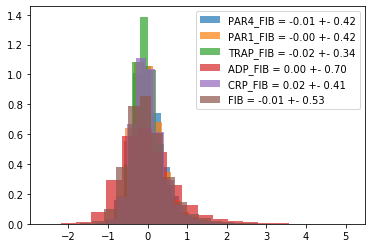

In [17]:
for p in predictions_agg:
    plt.hist(predictions_agg[p],alpha=0.7,bins=20,
             label="%s = %.2f +- %.2f" % (p, predictions_agg[p].mean(), predictions_agg[p].std()),density=True)
plt.legend()

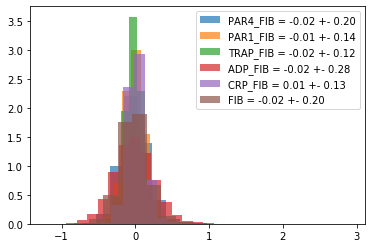

In [18]:
for p in predictions_sys:
    plt.hist(predictions_sys[p],alpha=0.7,bins=20,
             label="%s = %.2f +- %.2f" % (p, predictions_sys[p].mean(), predictions_sys[p].std()),density=True)
plt.legend()

In [19]:
predictions_agg -= predictions_agg.mean()
predictions_agg /= predictions_agg.std()
predictions_agg.to_hdf("%s/interval_predictions.hdf" % export_folder, key="predictions")

## Export for GWAS

In [20]:
predictions_agg.head()

,PAR4_FIB,PAR1_FIB,TRAP_FIB,ADP_FIB,CRP_FIB,FIB
[XN-10^11041][00-15_5][20141001_112923][ INT_116_3116300].116,-0.463513,-0.596038,-0.079893,-0.501437,-0.423036,-0.424426
[XN-10^11041][00-15_5][20140628_104817][ INT_116_6988400].116,-1.590170,-1.628887,-1.467105,-1.480886,-1.529809,-1.544555
[XN-10^11041][00-15_5][20140614_094203][ INT_116_5239200].116,0.341331,0.251202,0.101277,0.246509,0.307578,0.262783
[XN-10^11041][00-13_16][20130808_145000][ INT_116_2243300].116,0.513022,0.584504,0.426149,0.608930,0.616931,0.542091
[XN-10^11041][00-13_16][20130906_114308][ INT_116_4872300].116,0.638058,0.587401,0.571037,0.720729,0.480298,0.615049


In [21]:
meta = pd.read_hdf("%s/meta_recap.hdf" % export_folder,key="meta")

In [22]:
print(meta.ethnicPulse.value_counts())
print(meta.shape)
meta = meta.loc[meta.ethnicPulse == "Eng/W/Scot/NI/Brit"]
print(meta.shape)

Eng/W/Scot/NI/Brit      32520
Other White backgrnd     1572
White Irish               636
Unknown                   559
Not Disclosed             524
Asian- Indian             457
Black- Caribbean          243
Other Asian backgrnd      175
Mixed White+Asian         172
Mixed W+B Caribbean       141
Asian- Pakistani          133
AO Mixed/multiple EB      129
Chinese                   113
Any other group           102
Black- African             85
Mixed W+B African          56
Asian- Bangladeshi         37
A.O Black/Afr/Cbn          24
Arab                       11
Name: ethnicPulse, dtype: int64
(37703, 775)
(32520, 775)


In [23]:
matching = pd.read_csv("/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_phenotypes/INTERVAL_OmicsMap_20200514.csv", sep=",")

In [24]:
matching = matching.loc[~matching["Affymetrix_QC_bl"].isnull()]

In [25]:
matching["Affymetrix_QC_bl"] = matching["Affymetrix_QC_bl"].astype(int).astype(str)

In [26]:
matching.columns

Index(['identifier', 'Affymetrix_QC_bl', 'Affymetrix_gwasQC_bl',
       'Affymetrix_QC_24m', 'Affymetrix_gwasQC_24m'],
      dtype='object')

In [27]:
meta = pd.merge(matching,meta,left_on="identifier", right_on="valid_id")

In [28]:
meta["IID"] = meta["Affymetrix_QC_bl"]
meta["FID"] = meta["Affymetrix_QC_bl"]

In [29]:
meta.columns[:40]

Index(['identifier_x', 'Affymetrix_QC_bl', 'Affymetrix_gwasQC_bl',
       'Affymetrix_QC_24m', 'Affymetrix_gwasQC_24m', 'FileName', 'SampleNo',
       'Instrument', 'DateTime', 'DateTime_rank', 'SampleType',
       'WithinSampleRank', 'EpiCovId_bl', 'EpiCovId_24m', 'EpiCovId_48m',
       'EpiCovId_p3', 'machine', 'valid_id', 'identifier_y', 'sexPulse',
       'monthPulse', 'yearPulse', 'agePulse', 'ethnicPulse', 'attendanceDate',
       'centre', 'newDonor', 'recruitmentSource', 'ABORH', 'appointmentTime',
       'interval', 'outCome', 'StartDate_bl', 'ht_bl', 'wt_bl', 'health1_bl',
       'ethnic_bl', 'hrt_bl', 'pill_bl', 'menopause_bl'],
      dtype='object')

In [30]:
meta["sexPulse"].value_counts()

1    15578
2    15374
Name: sexPulse, dtype: int64

In [31]:
meta["cohort"] = meta.interval
meta.loc[~meta.EpiCovId_bl.isnull() & (meta.sexPulse == 1),"cohort"] = "MBL"
meta.loc[~meta.EpiCovId_bl.isnull() & (meta.sexPulse == 2),"cohort"] = "FBL"

In [32]:
meta.cohort.value_counts()

FBL    9451
MBL    9052
M12    2221
M10    2199
M08    2106
F16    2001
F14    1987
F12    1935
Name: cohort, dtype: int64

In [33]:
meta.set_index("FileName").shape

(30952, 782)

In [34]:
meta["cohort_covar"] = 0
for i, c in enumerate(meta["cohort"].unique().tolist()):
    meta.loc[meta["cohort"] == c,"cohort_covar"] = i

In [43]:
pcs = pd.read_csv("%s/principal_components/PC.eigenvec" % export_folder,sep="\t")
pcs["IID"] = pcs["IID"].astype(str)

In [41]:
meta["age_covar"] = RobustScaler().fit_transform(meta[["agePulse"]])

In [46]:
covar = pd.merge(features[["PLT_wb","MPV_wb","PDW_wb","PCT_wb"]],
                 meta.set_index("FileName")[["FID","IID","cohort_covar","sexPulse","age_covar"]],
                left_index=True,right_index=True)
covar = pd.merge(covar,pcs[pcs.columns[1:]],left_on="IID",right_on="IID")

In [47]:
covar.isnull().mean()

PLT_wb          0.0
MPV_wb          0.0
PDW_wb          0.0
PCT_wb          0.0
FID             0.0
IID             0.0
cohort_covar    0.0
sexPulse        0.0
age_covar       0.0
PC1             0.0
PC2             0.0
PC3             0.0
PC4             0.0
PC5             0.0
PC6             0.0
PC7             0.0
PC8             0.0
PC9             0.0
PC10            0.0
dtype: float64

In [48]:
covar = covar[["FID","IID","cohort_covar","sexPulse","age_covar","PLT_wb","MPV_wb","PDW_wb","PCT_wb","PC1","PC2","PC3","PC4","PC5"]]

In [49]:
covar.head()

,FID,IID,cohort_covar,sexPulse,age_covar,PLT_wb,MPV_wb,PDW_wb,PCT_wb,PC1,PC2,PC3,PC4,PC5
0,110018327792,110018327792,2,2,-0.631139,-0.458333,-0.750000,-0.678571,-1.000000,-0.003431,-0.004429,0.005799,0.005465,-0.004632
1,110018483652,110018483652,5,2,0.693835,-0.597222,1.000000,1.142857,-0.285714,0.006413,0.005157,0.008395,0.002881,0.008806
2,110001259381,110001259381,0,2,-0.714734,-0.861111,0.833333,0.857143,-0.714286,0.001189,-0.001928,0.007722,-0.014941,0.004064
3,110004412832,110004412832,0,2,0.535005,-0.736111,0.750000,0.785714,-0.571429,-0.009439,-0.007902,0.003113,-0.002499,-0.000451
4,110003866786,110003866786,3,2,0.815047,-0.166667,-0.416667,-0.357143,-0.285714,-0.001606,-0.000988,-0.006682,-0.002042,-0.003743


In [50]:
covar.to_csv("%s/covariates.csv" % export_folder, index=False,header=True, sep="\t")

In [51]:
phenos = pd.merge(predictions_agg,
                 meta.set_index("FileName")[["FID","IID"]],
                left_index=True,right_index=True)
phenos = phenos[["FID","IID"] + list(predictions_agg.columns)]

In [52]:
phenos.to_csv("%s/phenotypes.csv" % export_folder, index=False,header=True, sep="\t")

In [53]:
f_cols = list(features.columns)
features = pd.merge(features,
                 meta.set_index("FileName")[["FID","IID"]],
                left_index=True,right_index=True)
features = features[["FID","IID"] + f_cols]

In [54]:
features.to_csv("%s/features.csv" % export_folder, index=False,header=True, sep="\t")

In [55]:
with open("%s/ids.txt" % export_folder,"w") as f:
    for ID in phenos.FID.unique().tolist():
        f.write("%s\n" % ID)

In [56]:
export_folder

'/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing'

# run GWAS

In [3]:
import subprocess
phenos = pd.read_csv("%s/phenotypes.csv" % export_folder, sep="\t")
covar = pd.read_csv("%s/covariates.csv" % export_folder, sep="\t")

## GWAS of phenotypes

In [60]:
n_splits = 30
tag = "norm_ok"
for pheno in phenos.columns[2:]:

    command = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/BOLT-LMM_v2.3.4/bolt "
    for k in range(1,23):
        command += "--bim=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d.bim " % k
    # Only one fam file has to be specified
    command += "--fam=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_1.fam "
    for k in range(1,23):
        command += "--bed=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d.bed " % k
    command += "--lmm \
        --LDscoresFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/BOLT-LMM_v2.3.4/tables/LDSCORE.1000G_EUR.tab.gz \
        --phenoFile=%s/phenotypes.csv \
        --phenoCol=%s \
        --covarFile=%s/covariates.csv \
        --maxMissingPerSnp=0.1 \
        --qCovarCol=PLT_wb \
        --qCovarCol=MPV_wb \
        --qCovarCol=PCT_wb \
        --qCovarCol=PDW_wb \
        --qCovarCol=age_covar \
        --covarCol=sexPulse \
        --covarCol=cohort_covar \
        --covarMaxLevels=20 \
        --statsFile=%s/bolt_res_%s \
        --statsFileBgenSnps=%s/bolt_res_bgen_%s \
        --modelSnps=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/indep_snps \
        --bgenFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/alexander_only/impute_{1:22}_interval.bgen \
        --bgenMinMAF=1e-3 \
        --bgenMinINFO=0.3 \
        --sampleFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/alexander_only/interval.sample \
        --numThreads=%d" % (export_folder,
                            pheno,
                            export_folder,
                            export_folder,
                            pheno,
                            export_folder,
                            pheno,
                            n_splits)

    f_name = "/home/hv270/interval_slurm_calls/call_%s.sh" % pheno
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J %s\n" % (pheno))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    #f.write("#SBATCH -c %d\n" % n_splits)
    f.write("#SBATCH --time=10:00:00\n")
    f.write("#SBATCH -p skylake\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s.out\n" % (tag,pheno))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % pheno)
    p = subprocess.Popen("sbatch %s" % f_name,shell=True)
    p.wait()


Submitting PAR4_FIB
Submitting PAR1_FIB
Submitting TRAP_FIB
Submitting ADP_FIB
Submitting CRP_FIB
Submitting FIB


## GWAS of features

In [5]:
features.head()

,high_10_0,high_10_1,high_20_0,high_20_1,high_50_0,high_50_1,low_10_0,low_10_1,low_20_0,low_20_1,...,mode_1,S_0,S_1,iqr_0,iqr_1,corr,MPV_wb,PCT_wb,PDW_wb,PLT_wb
[XN-10^11041][00-15_5][20141001_112923][ INT_116_3116300].116,-1.216721,0.167404,-0.739240,0.300339,-0.162218,0.449912,-2.095965,-1.041256,-1.939709,-1.222672,...,-1.128165,0.191144,0.371316,0.132532,1.234871,0.142539,-1.416667,-0.571429,-1.035714,0.097222
[XN-10^11041][00-15_5][20140628_104817][ INT_116_6988400].116,0.512389,-0.532091,0.530238,-0.471025,0.441687,-0.314875,0.250156,-0.720891,0.116447,-0.820271,...,0.444352,0.967313,1.504484,0.281344,0.069848,0.418477,-0.750000,-1.000000,-0.678571,-0.458333
[XN-10^11041][00-15_5][20140614_094203][ INT_116_5239200].116,1.166945,-0.033822,1.062551,-0.045256,0.987633,0.036630,1.661541,0.338230,1.652553,0.348129,...,0.567618,0.118756,0.425957,0.015476,-0.922220,0.247815,1.000000,-0.285714,1.142857,-0.597222
[XN-10^11041][00-13_16][20130808_145000][ INT_116_2243300].116,0.616211,-0.347955,0.623018,-0.297589,0.512161,-0.429401,1.075472,-0.147520,1.063616,-0.009189,...,-0.420493,0.829441,0.202695,-0.432534,-0.457062,-0.358357,0.833333,-0.714286,0.857143,-0.861111
[XN-10^11041][00-13_16][20130906_114308][ INT_116_4872300].116,0.594799,0.406168,0.596421,0.444563,0.536050,0.477392,0.294502,0.599917,0.244817,0.638259,...,0.485224,1.028649,0.231348,0.569193,-0.372125,-0.254485,0.750000,-0.571429,0.785714,-0.736111


In [8]:
n_splits = 30
tag = "norm_ok"
for pheno in features.columns:

    command = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/BOLT-LMM_v2.3.4/bolt "
    for k in range(1,23):
        command += "--bim=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d.bim " % k
    # Only one fam file has to be specified
    command += "--fam=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_1.fam "
    for k in range(1,23):
        command += "--bed=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d.bed " % k
    command += "--lmm \
        --LDscoresFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/BOLT-LMM_v2.3.4/tables/LDSCORE.1000G_EUR.tab.gz \
        --phenoFile=%s/features.csv \
        --phenoCol=%s \
        --covarFile=%s/covariates.csv \
        --maxMissingPerSnp=0.1 \
        --qCovarCol=PLT_wb \
        --qCovarCol=MPV_wb \
        --qCovarCol=PCT_wb \
        --qCovarCol=PDW_wb \
        --qCovarCol=age_covar \
        --covarCol=sexPulse \
        --covarCol=cohort_covar \
        --covarMaxLevels=20 \
        --statsFile=%s/bolt_res_%s \
        --statsFileBgenSnps=%s/bolt_res_bgen_%s \
        --modelSnps=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/indep_snps \
        --bgenFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/alexander_only/impute_{1:22}_interval.bgen \
        --bgenMinMAF=1e-3 \
        --bgenMinINFO=0.3 \
        --sampleFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/alexander_only/interval.sample \
        --numThreads=%d" % (export_folder,
                            pheno,
                            export_folder,
                            export_folder,
                            pheno,
                            export_folder,
                            pheno,
                            n_splits)

    f_name = "/home/hv270/interval_slurm_calls/call_%s.sh" % pheno
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J %s\n" % (pheno))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    #f.write("#SBATCH -c %d\n" % n_splits)
    f.write("#SBATCH --time=10:00:00\n")
    f.write("#SBATCH -p skylake\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s.out\n" % (tag,pheno))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % pheno)
    p = subprocess.Popen("sbatch %s" % f_name,shell=True)
    p.wait()

Submitting high_10_0
Submitting high_10_1
Submitting high_20_0
Submitting high_20_1
Submitting high_50_0
Submitting high_50_1
Submitting low_10_0
Submitting low_10_1
Submitting low_20_0
Submitting low_20_1
Submitting low_50_0
Submitting low_50_1
Submitting mean_0
Submitting mean_1
Submitting ratio_10
Submitting ratio_20
Submitting mean_std_0
Submitting mean_std_1
Submitting mode_0
Submitting mode_1
Submitting S_0
Submitting S_1
Submitting iqr_0
Submitting iqr_1
Submitting corr
Submitting MPV_wb
Submitting PCT_wb
Submitting PDW_wb
Submitting PLT_wb


## GWAS of covariates

In [4]:
pcs = covar[["FID","IID"]+[c for c in covar if "_wb" not in c]]
pcs.to_csv("%s/non_sys_covars.csv" % export_folder, sep="\t",index=False,header=True)
sys_pheno = covar[["FID","IID"]+[c for c in covar if "_wb" in c]]
sys_pheno.to_csv("%s/sys_pheno.csv" % export_folder, sep="\t",index=False,header=True)

In [5]:
n_splits = 30
tag = "sys_pheno_test"
for pheno in sys_pheno.columns:

    command = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/BOLT-LMM_v2.3.4/bolt "
    for k in range(1,23):
        command += "--bim=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d.bim " % k
    # Only one fam file has to be specified
    command += "--fam=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_1.fam "
    for k in range(1,23):
        command += "--bed=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d.bed " % k
    command += "--lmm \
        --LDscoresFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/BOLT-LMM_v2.3.4/tables/LDSCORE.1000G_EUR.tab.gz \
        --phenoFile=%s/sys_pheno.csv \
        --phenoCol=%s \
        --covarFile=%s/non_sys_covars.csv \
        --maxMissingPerSnp=0.1 \
        --qCovarCol=age_covar \
        --covarCol=sexPulse \
        --covarCol=cohort_covar \
        --covarMaxLevels=20 \
        --statsFile=%s/sys_pheno_bolt_res_%s \
        --statsFileBgenSnps=%s/bolt_res_bgen_%s \
        --modelSnps=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/indep_snps \
        --bgenFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/alexander_only/impute_{1:22}_interval.bgen \
        --bgenMinMAF=5e-4 \
        --bgenMinINFO=0.5 \
        --sampleFile=/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/alexander_only/interval.sample \
        --numThreads=%d" % (export_folder,
                            pheno,
                            export_folder,
                            export_folder,
                            pheno,
                            export_folder,
                            pheno,
                            n_splits)

    f_name = "/home/hv270/interval_slurm_calls/call_%s.sh" % pheno
    f = open(f_name,"w+")
    f.write("#!/bin/sh\n")

    f.write("#SBATCH -J %s\n" % (pheno))
    f.write("#SBATCH -A ASTLE-SL2-CPU\n")
    f.write("#SBATCH -N 1\n")
    f.write("#SBATCH -n %d\n" % n_splits)
    #f.write("#SBATCH -c %d\n" % n_splits)
    f.write("#SBATCH --time=10:00:00\n")
    f.write("#SBATCH -p skylake\n")
    f.write("#SBATCH --output=/home/hv270/slurm_log/%s_%s.out\n" % (tag,pheno))
    f.write("export OMP_NUM_THREADS=%d\n" % n_splits)

    f.write(". /etc/profile.d/modules.sh\n")
    f.write("module purge\n")
    f.write("module load rhel7/default-peta4\n")
    f.write(command)
    f.close()

    print("Submitting %s" % pheno)
    p = subprocess.Popen("sbatch %s" % f_name,shell=True)
    p.wait()

Submitting FID
Submitting IID
Submitting PLT_wb
Submitting MPV_wb
Submitting PDW_wb
Submitting PCT_wb
